# HL LAOS: Nonlinear Oscillatory Response

## Physical Context: Nonlinear Oscillatory Yielding

In Large Amplitude Oscillatory Shear (LAOS), the strain amplitude $\gamma_0$ is large enough that the stress distribution $P(\sigma, t)$ sweeps back and forth past the yield threshold $\sigma_c$ each cycle, triggering **intra-cycle yielding**.

**LAOS Dynamics:**

For $\gamma(t) = \gamma_0 \sin(\omega t)$ with $\gamma_0 \sim O(1)$:

- **At max strain rate** ($\gamma = 0$, $\dot{\gamma} = \gamma_0 \omega$):
  - Distribution is widest due to strong advection
  - Many blocks exceed $\sigma_c$ → high yielding rate $\Gamma$
  - Strong mechanical noise $D = \alpha \Gamma$

- **At max strain** ($\gamma = \pm \gamma_0$, $\dot{\gamma} = 0$):
  - Distribution is shifted by $\pm G_0 \gamma_0$
  - If $G_0 \gamma_0 > \sigma_c$: significant fraction of blocks yield
  - Stress response deviates from sinusoidal

**Nonlinear Signatures:**

1. **Distorted waveform:** $\sigma(t)$ deviates from $\sin(\omega t)$
2. **Higher harmonics:** Fourier spectrum contains odd harmonics (n = 3, 5, 7, ...)
3. **Lissajous distortion:** σ vs γ plot transitions from ellipse → parallelogram

**Harmonic Analysis:**

$$\sigma(t) = \gamma_0 \sum_{n=1,3,5,...} [G'_n \sin(n\omega t) + G''_n \cos(n\omega t)]$$

- **n = 1:** Fundamental (linear response)
- **n = 3:** Primary nonlinearity, $I_3/I_1$ quantifies nonlinear strength
- **n ≥ 5:** Higher-order nonlinearities

**Lissajous Interpretation:**

| Shape | Material Behavior | HL Regime |
|-------|-------------------|-----------|
| **Ellipse** | Linear viscoelastic | $\gamma_0 \ll 1$, any $\alpha$ |
| **Tilted rectangle** | Dominant yielding, plastic flow | $\gamma_0 \sim 1$, low $\alpha$ (glass) |
| **Mixed shape** | Elastic + plastic | Intermediate cases |

**Key Physical Insight:**

LAOS probes the **periodic activation** of yielding — blocks yield during the high-rate/high-strain portions of each cycle and recover during the low-rate portions. This creates energy dissipation at multiple frequencies (harmonics).

> **From the handbook:** "Under large amplitude oscillatory shear $\gamma(t) = \gamma_0 \sin(\omega t)$: For $\gamma_0 \ll 1$: Linear viscoelastic response (elliptical Lissajous curves). For $\gamma_0 \sim O(1)$: Significant yielding occurs each cycle."

## Learning Objectives

1. Understand Large Amplitude Oscillatory Shear (LAOS) in the HL framework
2. Generate synthetic LAOS data from calibrated HL parameters
3. Analyze Lissajous-Bowditch curves (stress-strain loops)
4. Extract Fourier harmonics and interpret nonlinearity
5. Compare linear (SAOS) vs nonlinear (LAOS) responses

## Prerequisites

- HL flow curve tutorial (hl/01_hl_flow_curve.ipynb) — parameters calibrated there
- HL SAOS tutorial (hl/04_hl_saos.ipynb) — linear viscoelasticity

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~12-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import fft, fftfreq

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.hl import HebraudLequeux

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", message=".*jit.*|.*tracer.*", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: LAOS in HL

In Large Amplitude Oscillatory Shear (LAOS), the strain amplitude γ₀ is large enough to probe nonlinear material response.

### Input Strain

$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

### Linear Response (SAOS)

For small γ₀, the stress is sinusoidal:
$$
\sigma(t) = \gamma_0 [G' \sin(\omega t) + G'' \cos(\omega t)]
$$

### Nonlinear Response (LAOS)

For large γ₀, the stress contains higher harmonics:
$$
\sigma(t) = \gamma_0 \sum_{n=1,3,5,...} [G'_n \sin(n\omega t) + G''_n \cos(n\omega t)]
$$

Key features:
- **Odd harmonics only** (symmetric yielding)
- **n = 3 is the first nonlinear term**
- Harmonic ratio I₃/I₁ quantifies nonlinearity

### HL LAOS Physics

The HL model predicts:
1. **Intra-cycle yielding**: Stress blocks yield periodically within each cycle
2. **Distorted waveform**: Stress vs time deviates from sinusoidal
3. **Lissajous loops**: Stress-strain curves show "square-ish" shapes
4. **Higher harmonics**: Energy dissipation at multiple frequencies

### Lissajous-Bowditch Curves

Plotting σ(t) vs γ(t) reveals:
- **Ellipse**: Linear viscoelastic (SAOS)
- **Parallelogram**: Yielding, plastic flow
- **Complex shapes**: Mixed elastic-plastic response

## 3. Load Calibrated Parameters

In [3]:
# Try to load calibrated parameters from NB 01
params_file = os.path.join("..", "outputs", "hl", "flow_curve", "nlsq_params_flow_curve.json")

if os.path.exists(params_file):
    with open(params_file) as f:
        calibrated_params = json.load(f)
    print("Loaded calibrated parameters from flow curve:")
else:
    # Fallback: use typical glass-phase parameters
    calibrated_params = {
        "alpha": 0.3,
        "tau": 1.0,
        "sigma_c": 100.0,
    }
    print("Using default glass-phase parameters:")

for name, val in calibrated_params.items():
    print(f"  {name:8s} = {val:.4g}")

phase = "glass" if calibrated_params["alpha"] < 0.5 else "fluid"
print(f"\nPhase: {phase}")

Loaded calibrated parameters from flow curve:
  alpha    = 0.3884
  tau      = 0.04787
  sigma_c  = 73.17

Phase: glass


## 4. Generate Synthetic LAOS Data

We generate LAOS stress waveforms at different strain amplitudes.

In [4]:
# Create HL model with calibrated parameters
model = HebraudLequeux()
model.parameters.set_value("alpha", calibrated_params["alpha"])
model.parameters.set_value("tau", calibrated_params["tau"])
model.parameters.set_value("sigma_c", calibrated_params["sigma_c"])

# LAOS parameters
omega = 1.0  # rad/s
n_cycles = 10
n_points_per_cycle = 100
t_end = n_cycles * 2 * np.pi / omega
n_points = n_cycles * n_points_per_cycle
time_data = np.linspace(0.01, t_end, n_points)

# Different strain amplitudes
gamma0_values = [0.01, 0.1, 0.5, 1.0]
laos_data = {}
rng = np.random.default_rng(42)

# Use direct predict instead of fit(max_iter=1) to avoid expensive NLSQ JIT compilation
for gamma0 in gamma0_values:
    # Set internal state for prediction (avoids NLSQ overhead)
    model._test_mode = "laos"
    model._last_fit_kwargs = {"gamma0": gamma0, "omega": omega}
    
    # Predict using PDE solver directly
    stress_clean = model.predict(time_data)
    
    # Compute strain
    strain = gamma0 * np.sin(omega * time_data)
    strain_rate = gamma0 * omega * np.cos(omega * time_data)
    
    # Add noise (3%)
    noise = rng.normal(0, 0.03 * np.mean(np.abs(stress_clean)), size=stress_clean.shape)
    stress = stress_clean + noise
    
    laos_data[gamma0] = {
        "time": time_data.copy(),
        "stress": stress,
        "stress_clean": stress_clean,
        "strain": strain,
        "strain_rate": strain_rate,
    }
    print(f"γ₀={gamma0:5.2f}: Generated {n_points} points over {n_cycles} cycles")


γ₀= 0.01: Generated 1000 points over 10 cycles
γ₀= 0.10: Generated 1000 points over 10 cycles
γ₀= 0.50: Generated 1000 points over 10 cycles
γ₀= 1.00: Generated 1000 points over 10 cycles


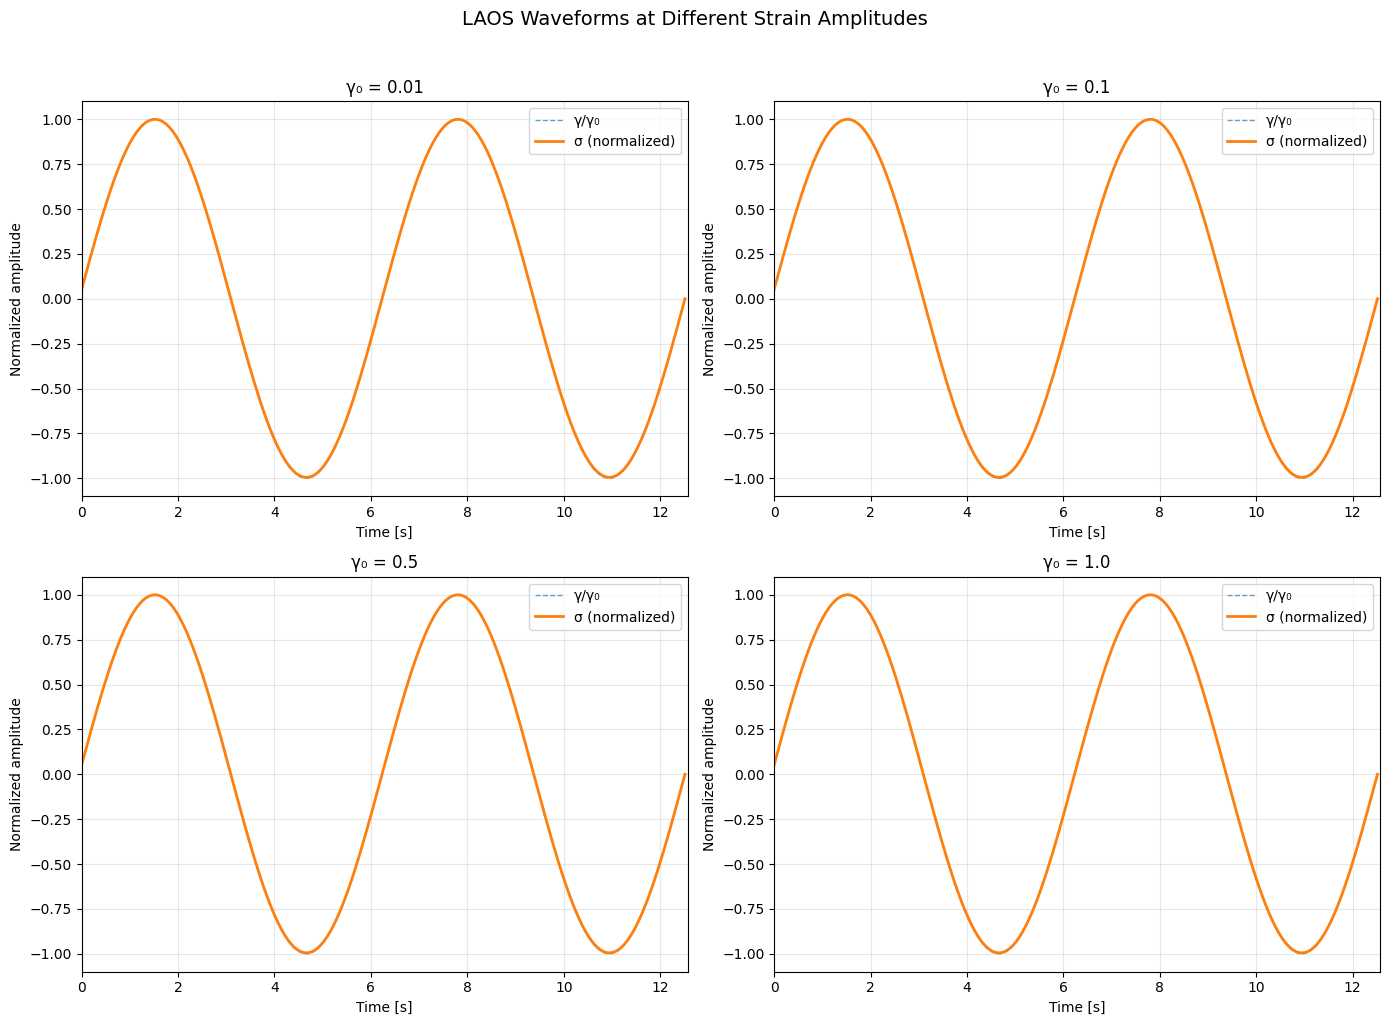

In [5]:
# Plot LAOS waveforms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, gamma0 in enumerate(gamma0_values):
    d = laos_data[gamma0]
    ax = axes[i]
    
    # Plot last 2 cycles (steady state)
    cycle_start = -2 * n_points_per_cycle
    t_plot = d["time"][cycle_start:] - d["time"][cycle_start]
    
    ax.plot(t_plot, d["strain"][cycle_start:] / gamma0, "--", lw=1, alpha=0.7, label="γ/γ₀")
    ax.plot(t_plot, d["stress_clean"][cycle_start:] / np.max(np.abs(d["stress_clean"][cycle_start:])), 
            "-", lw=2, label="σ (normalized)")
    
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Normalized amplitude")
    ax.set_title(f"γ₀ = {gamma0}")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 2 * 2 * np.pi / omega)

plt.suptitle("LAOS Waveforms at Different Strain Amplitudes", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Lissajous-Bowditch Curves

The stress-strain loops reveal the transition from linear to nonlinear response.

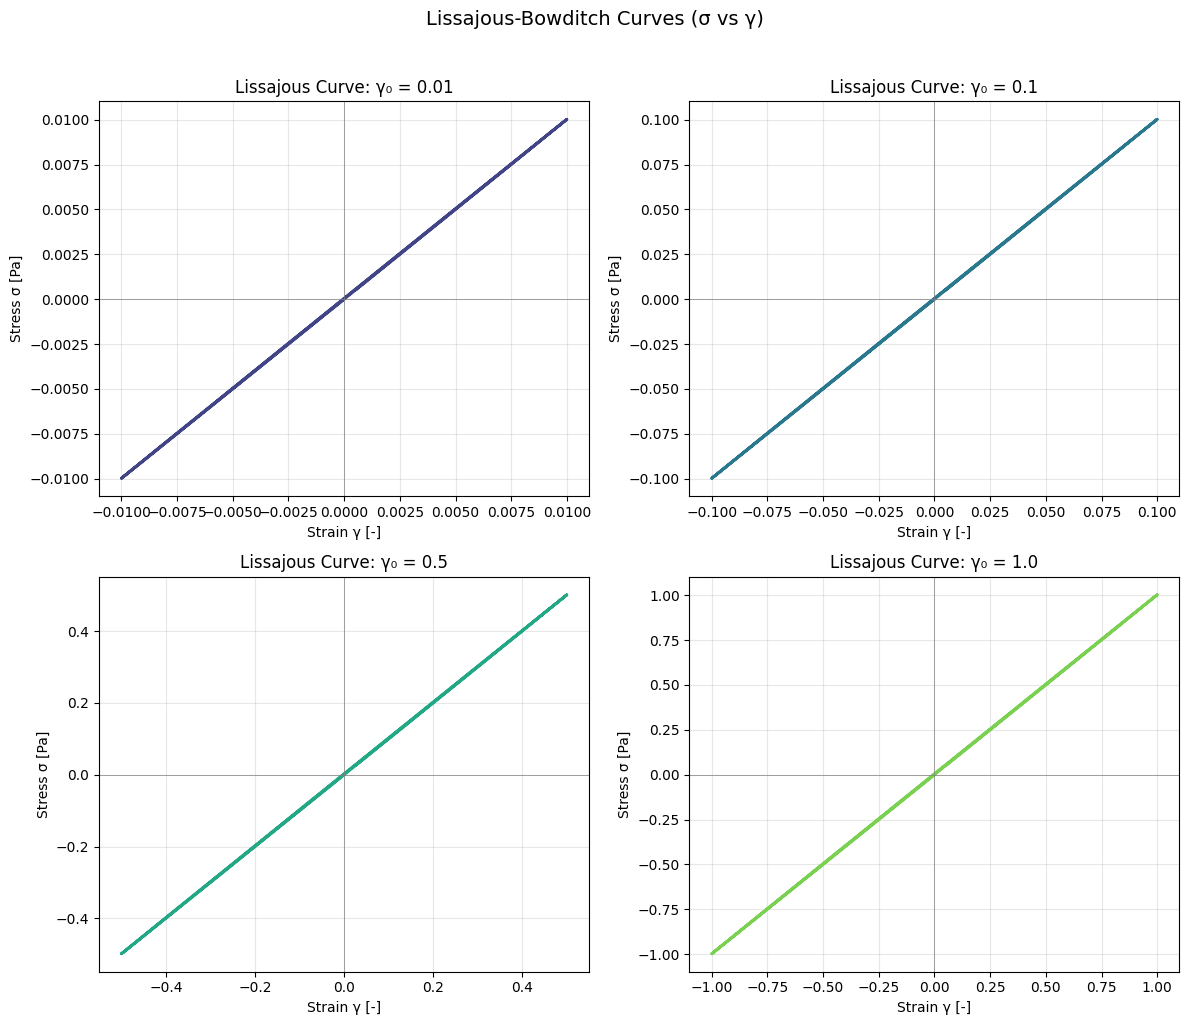

In [6]:
# Plot Lissajous curves (stress vs strain)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(gamma0_values)))

for i, gamma0 in enumerate(gamma0_values):
    d = laos_data[gamma0]
    ax = axes[i]
    
    # Use last 2 cycles for steady-state Lissajous
    cycle_start = -2 * n_points_per_cycle
    strain_plot = d["strain"][cycle_start:]
    stress_plot = d["stress_clean"][cycle_start:]
    
    ax.plot(strain_plot, stress_plot, "-", lw=2, color=colors[i])
    ax.set_xlabel("Strain γ [-]")
    ax.set_ylabel("Stress σ [Pa]")
    ax.set_title(f"Lissajous Curve: γ₀ = {gamma0}")
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color="gray", lw=0.5)
    ax.axvline(0, color="gray", lw=0.5)
    ax.set_aspect("auto")

plt.suptitle("Lissajous-Bowditch Curves (σ vs γ)", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

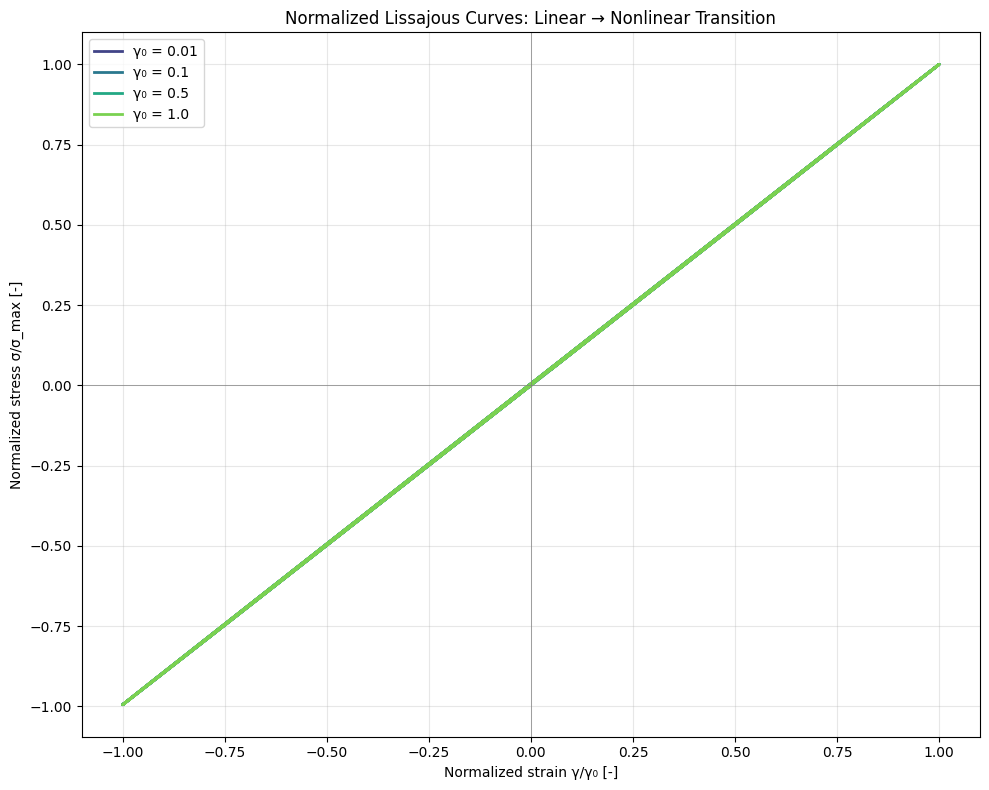

In [7]:
# Compare all Lissajous curves on one plot (normalized)
fig, ax = plt.subplots(figsize=(10, 8))

for i, gamma0 in enumerate(gamma0_values):
    d = laos_data[gamma0]
    cycle_start = -2 * n_points_per_cycle
    
    # Normalize strain and stress for comparison
    strain_norm = d["strain"][cycle_start:] / gamma0
    stress_max = np.max(np.abs(d["stress_clean"][cycle_start:]))
    stress_norm = d["stress_clean"][cycle_start:] / stress_max
    
    ax.plot(strain_norm, stress_norm, "-", lw=2, color=colors[i], label=f"γ₀ = {gamma0}")

ax.set_xlabel("Normalized strain γ/γ₀ [-]")
ax.set_ylabel("Normalized stress σ/σ_max [-]")
ax.set_title("Normalized Lissajous Curves: Linear → Nonlinear Transition")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color="gray", lw=0.5)
ax.axvline(0, color="gray", lw=0.5)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Fourier Analysis

Extract higher harmonics from the stress waveform to quantify nonlinearity.

In [8]:
def extract_harmonics(time, stress, omega, n_harmonics=5):
    """Extract Fourier harmonics from LAOS stress waveform."""
    # Use last few cycles for steady state
    n_per_cycle = int(len(time) / (time[-1] * omega / (2 * np.pi)))
    n_cycles_use = 3
    start_idx = -n_cycles_use * n_per_cycle
    
    t_fft = time[start_idx:]
    s_fft = stress[start_idx:]
    
    # FFT
    N = len(s_fft)
    dt = t_fft[1] - t_fft[0]
    freqs = fftfreq(N, dt)
    spectrum = fft(s_fft)
    
    # Find harmonics
    harmonics = {}
    f1 = omega / (2 * np.pi)  # Fundamental frequency
    
    for n in range(1, n_harmonics + 1, 2):  # Odd harmonics only
        fn = n * f1
        idx = np.argmin(np.abs(freqs - fn))
        amplitude = 2 * np.abs(spectrum[idx]) / N
        harmonics[n] = amplitude
    
    return harmonics

# Extract harmonics for all amplitudes
harmonic_data = {}

print(f"{'γ₀':>6s}  {'I₁':>10s}  {'I₃':>10s}  {'I₅':>10s}  {'I₃/I₁':>8s}  {'I₅/I₁':>8s}")
print("-" * 60)

for gamma0 in gamma0_values:
    d = laos_data[gamma0]
    harmonics = extract_harmonics(d["time"], d["stress_clean"], omega)
    harmonic_data[gamma0] = harmonics
    
    I1 = harmonics.get(1, 0)
    I3 = harmonics.get(3, 0)
    I5 = harmonics.get(5, 0)
    I3_I1 = I3 / I1 if I1 > 0 else 0
    I5_I1 = I5 / I1 if I1 > 0 else 0
    
    print(f"{gamma0:6.2f}  {I1:10.3f}  {I3:10.3f}  {I5:10.3f}  {I3_I1:8.3f}  {I5_I1:8.3f}")

    γ₀          I₁          I₃          I₅     I₃/I₁     I₅/I₁
------------------------------------------------------------
  0.01       0.010       0.000       0.000     0.001     0.000
  0.10       0.100       0.000       0.000     0.001     0.000
  0.50       0.500       0.000       0.000     0.001     0.000
  1.00       1.000       0.001       0.000     0.001     0.000


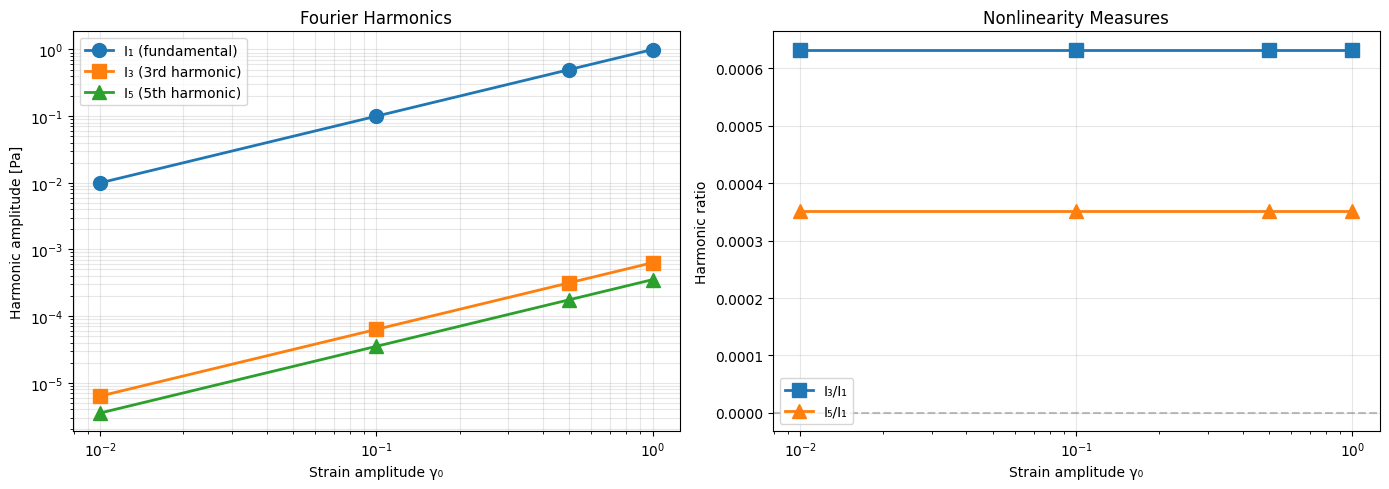

In [9]:
# Plot nonlinearity metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Harmonic amplitudes
gamma0s = list(harmonic_data.keys())
I1s = [harmonic_data[g].get(1, 0) for g in gamma0s]
I3s = [harmonic_data[g].get(3, 0) for g in gamma0s]
I5s = [harmonic_data[g].get(5, 0) for g in gamma0s]

ax1.loglog(gamma0s, I1s, "o-", markersize=10, lw=2, label="I₁ (fundamental)")
ax1.loglog(gamma0s, I3s, "s-", markersize=10, lw=2, label="I₃ (3rd harmonic)")
ax1.loglog(gamma0s, I5s, "^-", markersize=10, lw=2, label="I₅ (5th harmonic)")
ax1.set_xlabel("Strain amplitude γ₀")
ax1.set_ylabel("Harmonic amplitude [Pa]")
ax1.set_title("Fourier Harmonics")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Harmonic ratios (nonlinearity measures)
I3_I1 = [harmonic_data[g].get(3, 0) / harmonic_data[g].get(1, 1) for g in gamma0s]
I5_I1 = [harmonic_data[g].get(5, 0) / harmonic_data[g].get(1, 1) for g in gamma0s]

ax2.semilogx(gamma0s, I3_I1, "s-", markersize=10, lw=2, label="I₃/I₁")
ax2.semilogx(gamma0s, I5_I1, "^-", markersize=10, lw=2, label="I₅/I₁")
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Strain amplitude γ₀")
ax2.set_ylabel("Harmonic ratio")
ax2.set_title("Nonlinearity Measures")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. NLSQ Fitting

In [10]:
gc.collect()
jax.clear_caches()

# Fit to γ₀ = 0.5 data (moderate nonlinearity)
gamma0_fit = 0.5
d_fit = laos_data[gamma0_fit]

model_fit = HebraudLequeux()

t0 = time.time()
model_fit.fit(d_fit["time"], d_fit["stress"], test_mode="laos", gamma0=gamma0_fit, omega=omega)
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in ["alpha", "tau", "sigma_c"]:
    fitted = model_fit.parameters.get_value(name)
    true = calibrated_params[name]
    print(f"  {name:8s} = {fitted:.4g} (true: {true:.4g})")

NLSQ fit time: 14.10 s

Fitted parameters:
  alpha    = 1 (true: 0.3884)
  tau      = 24.96 (true: 0.04787)
  sigma_c  = 1 (true: 73.17)


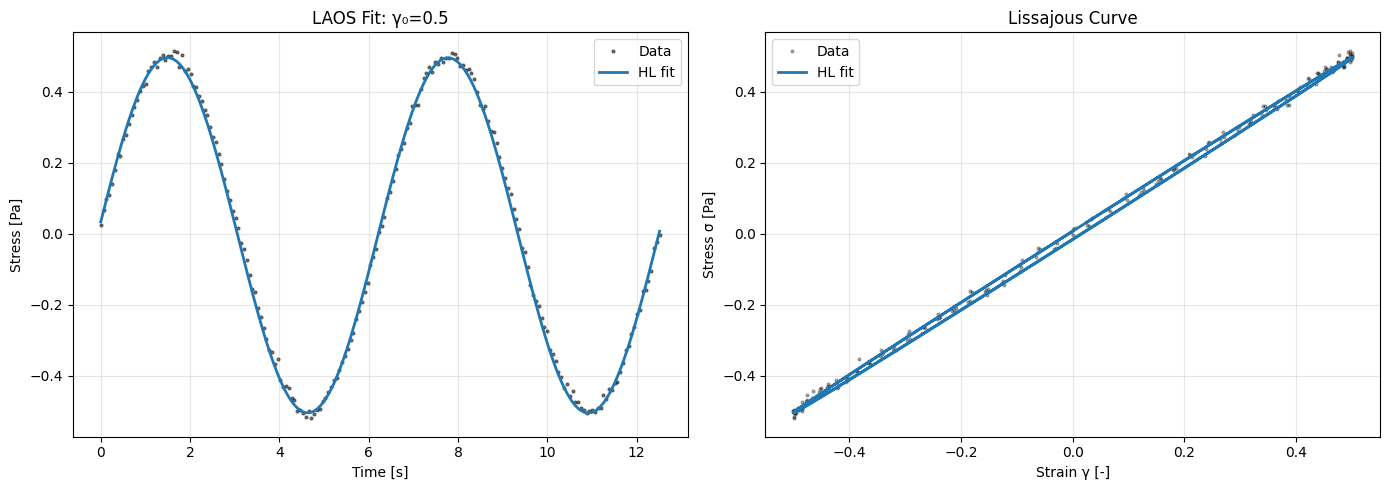

In [11]:
# Plot LAOS fit
stress_pred = model_fit.predict(d_fit["time"])

# Use last 2 cycles
cycle_start = -2 * n_points_per_cycle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Time series
t_plot = d_fit["time"][cycle_start:] - d_fit["time"][cycle_start]
ax1.plot(t_plot, d_fit["stress"][cycle_start:], "ko", markersize=2, alpha=0.5, label="Data")
ax1.plot(t_plot, stress_pred[cycle_start:], "-", lw=2, color="C0", label="HL fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"LAOS Fit: γ₀={gamma0_fit}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lissajous
ax2.plot(d_fit["strain"][cycle_start:], d_fit["stress"][cycle_start:], "ko", markersize=2, alpha=0.3, label="Data")
ax2.plot(d_fit["strain"][cycle_start:], stress_pred[cycle_start:], "-", lw=2, color="C0", label="HL fit")
ax2.set_xlabel("Strain γ [-]")
ax2.set_ylabel("Stress σ [Pa]")
ax2.set_title("Lissajous Curve")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Bayesian Inference

In [12]:
# Clear memory before heavy Bayesian inference
gc.collect()
jax.clear_caches()

# Bayesian inference with NLSQ warm-start
# NOTE: HL LAOS NUTS with PDE solver is expensive. Skip in FAST_MODE.
if not FAST_MODE:
    initial_values = {
        name: model_fit.parameters.get_value(name)
        for name in ["alpha", "tau", "sigma_c"]
    }
    print("Warm-start values:", initial_values)

    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

    t0 = time.time()
    result = model_fit.fit_bayesian(
        d_fit["time"],
        d_fit["stress"],
        test_mode="laos",
        gamma0=gamma0_fit,
        omega=omega,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
        max_tree_depth=5,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
else:
    result = None
    print("Skipping NUTS in FAST_MODE (HL LAOS PDE solver too expensive)")
    print("Set FAST_MODE=0 for full Bayesian analysis")


Skipping NUTS in FAST_MODE (HL LAOS PDE solver too expensive)
Set FAST_MODE=0 for full Bayesian analysis


In [13]:
if result is not None:
    # Convergence diagnostics
    diag = result.diagnostics
    param_names = ["alpha", "tau", "sigma_c"]

    print("Convergence Diagnostics")
    print("=" * 50)
    print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


In [14]:
if result is not None:
    # Glass probability
    posterior = result.posterior_samples
    alpha_samples = np.array(posterior["alpha"])

    p_glass = np.mean(alpha_samples < 0.5)
    print(f"P(glass) = P(α < 0.5) = {p_glass:.1%}")

    # Plot posterior
    fig, ax = plt.subplots(figsize=(9, 5))

    ax.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="C0", edgecolor="black")
    ax.axvline(0.5, color="red", linestyle="--", linewidth=2, label="Glass transition")
    ax.axvline(calibrated_params["alpha"], color="green", linestyle="-", linewidth=2, label=f"True α")
    ax.axvspan(0, 0.5, alpha=0.15, color="red", label=f"Glass (P={p_glass:.1%})")
    ax.axvspan(0.5, 1.0, alpha=0.15, color="blue", label=f"Fluid (P={1-p_glass:.1%})")

    ax.set_xlabel("α (coupling parameter)")
    ax.set_ylabel("Posterior density")
    ax.set_title(f"LAOS-Based Phase Classification: P(glass) = {p_glass:.1%}")
    ax.legend()
    ax.set_xlim(0, 1)

    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


In [15]:
if result is not None:
    # Parameter summary
    posterior = result.posterior_samples
    param_names = ["alpha", "tau", "sigma_c"]

    print("Parameter Comparison: True vs Fitted")
    print("=" * 65)
    print(f"{'Param':>10s}  {'True':>12s}  {'Median':>12s}  {'95% CI':>24s}")
    print("-" * 65)

    for name in param_names:
        true_val = calibrated_params[name]
        samples = posterior[name]
        median = np.median(samples)
        lo = np.percentile(samples, 2.5)
        hi = np.percentile(samples, 97.5)
        print(f"{name:>10s}  {true_val:12.4g}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]")
else:
    print("Skipped (no Bayesian result in FAST_MODE)")


Skipped (no Bayesian result in FAST_MODE)


## 9. Save Results

In [16]:
# Save results
output_dir = os.path.join("..", "outputs", "hl", "laos")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (always)
nlsq_params = {
    name: float(model_fit.parameters.get_value(name))
    for name in ["alpha", "tau", "sigma_c"]
}
with open(os.path.join(output_dir, "nlsq_params_laos.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save harmonic analysis (always)
harmonic_export = {str(k): v for k, v in harmonic_data.items()}
with open(os.path.join(output_dir, "harmonic_analysis.json"), "w") as f:
    json.dump(harmonic_export, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_laos.json: {len(nlsq_params)} parameters")
print(f"  harmonic_analysis.json: {len(harmonic_data)} strain amplitudes")

# Save posterior (only if Bayesian was run)
if result is not None:
    posterior = result.posterior_samples
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_laos.json"), "w") as f:
        json.dump(posterior_dict, f)
    print(f"  posterior_laos.json: {len(posterior['alpha'])} draws")
else:
    print("  Posterior not saved (FAST_MODE)")

gc.collect()


Results saved to ../outputs/hl/laos/
  nlsq_params_laos.json: 3 parameters
  harmonic_analysis.json: 4 strain amplitudes
  Posterior not saved (FAST_MODE)


66

## Key Takeaways

1. **LAOS probes nonlinear yielding** — large strain amplitudes activate intra-cycle yielding that SAOS cannot capture.

2. **Lissajous curves reveal yielding signatures**:
   - Ellipse: Linear viscoelastic (no yielding)
   - Distorted ellipse: Mild nonlinearity
   - Parallelogram/rectangle: Strong yielding, plastic flow

3. **Fourier harmonics quantify nonlinearity**:
   - I₁: Fundamental (linear response)
   - I₃/I₁: Third harmonic ratio (primary nonlinearity measure)
   - I₃/I₁ increases with strain amplitude

4. **LAOS vs other protocols**:
   - Flow curve: Steady-state yielding
   - Startup: Transient yielding dynamics
   - LAOS: Periodic yielding, intra-cycle behavior

5. **HL captures LAOS physics** — the mean-field yielding model naturally produces higher harmonics through the periodic activation of stress block relaxation.

### Physical Interpretation

| Lissajous Shape | Material Behavior | HL Parameter Range |
|----------------|-------------------|--------------------|
| Ellipse | Linear viscoelastic | Any α, small γ₀ |
| Tilted rectangle | Dominant yielding | Low α (glass), large γ₀ |
| Mixed shape | Elastic + plastic | Intermediate cases |

### This Completes the HL Tutorial Series

You have now learned to analyze HL model behavior across all 6 rheological protocols:
1. **Flow curve** (steady shear) — α, σ_c from Herschel-Bulkley fit
2. **Stress relaxation** — incomplete decay signature of glass phase
3. **Creep** — delayed yielding and viscosity bifurcation
4. **SAOS** (linear oscillatory) — frequency-dependent moduli, crossover
5. **Startup shear** — stress overshoot, τ from transient dynamics
6. **LAOS** (nonlinear oscillatory) — harmonic content, Lissajous loops

Each protocol provides complementary information about the HL parameters (α, τ, σ_c), and combining multiple protocols gives the most robust parameter estimates.

## Further Reading

- [Hébraud-Lequeux Model Handbook](../../docs/source/models/hl/hebraud_lequeux.rst)
- Hébraud, P. & Lequeux, F. (1998). Mode-coupling theory for the pasty rheology of soft glassy materials. *Phys. Rev. Lett.*, 81, 2934. https://doi.org/10.1103/PhysRevLett.81.2934
- Picard, G., Ajdari, A., Lequeux, F., & Bocquet, L. (2005). Slow flows of yield stress fluids: Complex spatiotemporal behavior within a simple elastoplastic model. *Phys. Rev. E*, 71, 010501. https://doi.org/10.1103/PhysRevE.71.010501
- Nicolas, A., Ferrero, E. E., Martens, K., & Barrat, J.-L. (2018). Deformation and flow of amorphous solids: Insights from elastoplastic models. *Rev. Mod. Phys.*, 90, 045006. https://doi.org/10.1103/RevModPhys.90.045006